<a href="https://colab.research.google.com/github/thunderstruck/climbicus/blob/liucija%2Fcastle-cafe-grades/model_training/train_model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Define callbacks


In [1]:
import io
import itertools
import os
import time

import numpy as np
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import skimage
import tensorflow as tf
from keras.callbacks import Callback, CSVLogger, EarlyStopping, LambdaCallback, ModelCheckpoint, TensorBoard, LearningRateScheduler

logs_base_dir = "callbacks"


def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image


def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype("float") / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    return figure


def log_confusion_matrix(epoch, logs, model, validation_generator, log_dir):
    # Use the model to predict the values from the validation dataset.
    y_pred_raw = model.predict_generator(
        validation_generator, validation_generator.samples // validation_generator.batch_size
    )
    y_pred = np.argmax(y_pred_raw, axis=1)
    cm = confusion_matrix(validation_generator.classes, y_pred)
    # Calculate the confusion matrix.
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm, class_names=list(validation_generator.class_indices.keys()))
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    cm_dir = os.path.join(log_dir, "cm")
    file_writer_cm = tf.summary.create_file_writer(cm_dir)
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)


class LRTensorBoard(TensorBoard):
    def __init__(self, log_dir, **kwargs):
        super().__init__(log_dir=log_dir, **kwargs)

    def on_epoch_end(self, epoch, logs=None):
        logs.update({"lr": tf.keras.backend.eval(self.model.optimizer.lr)})  # Store learning rate as lr in the event folder
        super().on_epoch_end(epoch, logs)


class TensorBoardImage(Callback):
    def __init__(self, tag, log_dir):
        super().__init__()
        self.tag = tag
        self.log_dir = log_dir

    def on_epoch_end(self, epoch, logs={}):
        # Load image
        img = skimage.data.astronaut()
        # Do something to the image
        img = (255 * skimage.util.random_noise(img)).astype("uint8")

        td_dir = os.path.join(self.log_dir, "td")
        writer = tf.summary.create_file_writer(td_dir)
        with writer.as_default():
            img = np.reshape(img, (-1, 512, 512, 3))
            tf.summary.image("Training data", img, step=epoch)


def exponential_decay(lr0, s):
  def exponential_decay_fn(epoch):
    return lr0 * 0.1 ** (epoch/s)
  return exponential_decay_fn


def get_callbacks(model_name, model, train_generator, validation_generator):
    model_id = time.strftime("%Y-%m-%d_%H-%M-%S")
    callback_csv = CSVLogger(
        filename=os.path.join(logs_base_dir, f"{model_name}_{model_id}.csv"), separator=",", append=False
    )
    os.makedirs(os.path.join(logs_base_dir, "models"), exist_ok=True)
    callback_model = ModelCheckpoint(
        filepath=os.path.join(logs_base_dir, "models", f"{model_name}_{model_id}.hdf5"),
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        period=3,
    )
    tensorboard_log_dir = os.path.join(logs_base_dir, "logs", f"{model_name}_{model_id}")
    callback_tensorboard = TensorBoard(
        log_dir=tensorboard_log_dir,
        histogram_freq=0,
        write_graph=True,
        write_grads=True,
        batch_size=train_generator.samples / train_generator.batch_size,
        write_images=True,
    )
    callback_learning_rate = LRTensorBoard(log_dir=os.path.join(logs_base_dir, 'logs', f'{model_name}_{model_id}'))

    callback_early_stopping = EarlyStopping(monitor="val_loss", mode="auto", verbose=1, patience=5)
    tbi_callback = TensorBoardImage("Example image", tensorboard_log_dir)
    cm_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: log_confusion_matrix(
            epoch, logs, model, validation_generator, tensorboard_log_dir
        )
    )

    exponential_decay_fn = exponential_decay(lr0=0.0001, s=100)
    lr_scheduler = LearningRateScheduler(exponential_decay_fn)

    return [
#         callback_csv,
        callback_model,
        callback_tensorboard,
        # callback_learning_rate,
        callback_early_stopping,
        # tbi_callback,
#         cm_callback,
        lr_scheduler,
    ]


Using TensorFlow backend.


#### Imports

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -a 'drive/My Drive/LiuAnd/climbicus/callbacks/.' /content/callbacks/

In [0]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.utils.class_weight import compute_class_weight

In [0]:
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img
from keras.models import load_model
from tensorboard import notebook
from keras.metrics import top_k_categorical_accuracy

In [0]:
from keras import models
from keras import layers
from keras import optimizers

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

#### Setup

In [0]:
def save_class_indices(generator, filename):
    class_indices_opp = {v:k for k, v in generator.class_indices.items()}
    
    def save_obj(obj, name ):
        with open(name + '.pkl', 'wb') as f:
            pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
    save_obj(class_indices_opp, filename)
    return generator.class_indices, class_indices_opp

In [0]:
def get_training_directories(base_dir):
    train_dir = os.path.join(base_dir, 'train')
    validation_dir = os.path.join(base_dir, 'val')
    test_dir = os.path.join(base_dir, 'test')
    return train_dir, validation_dir, test_dir

In [0]:
base_dir = 'drive/My Drive/LiuAnd/climbicus/categories_castle_cafe/categories_castle_cafe_categories_blurred_photos_removed/'
# base_dir = 'drive/My Drive/LiuAnd/climbicus/categories_castle_cafe/categories_castle_cafe_categories_2_photos/'
no_cats = 46

In [0]:
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg16
from keras.applications.inception_v3 import preprocess_input as preprocess_input_inception
from keras.applications.xception import preprocess_input as preprocess_input_xception

def get_cnn_data_generators(cnn):
    if cnn == 'vgg16':
      pre_processor = preprocess_input_vgg16
    elif cnn == 'inception':
      pre_processor = preprocess_input_inception
    elif cnn == 'xception':
      pre_processor = preprocess_input_xception
    else:
      raise ValueError(f'Unknown pre-trained CNN. Got {cnn} whereas vgg16, inception or exception is expected.')

    train_datagen = ImageDataGenerator(
        preprocessing_function=pre_processor,
        brightness_range=(0.003, 1.6),
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    test_datagen = ImageDataGenerator(preprocessing_function=pre_processor)
    return train_datagen, test_datagen
    

In [0]:
def get_image_batches(train_datagen, test_datagen, batch_size, cnn):
    # Different pre-trained CNN's use different target images sizes as input 
    if cnn == 'vgg16':
      target_size = (224, 224)  # All images will be resized to 224x224
    elif cnn == 'inception':
      target_size = (299, 299)  # All images will be resized to 299x99
    elif cnn == 'xception':
      target_size = (299, 299)  # All images will be resized to 299x299
    else:
      raise ValueError(f'Unknown pre-trained CNN. Got {cnn} whereas vgg16, inception or exception is expected.') 
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)
    
    # TODO: Test generator
    return train_generator, validation_generator

In [0]:
def get_conv_base(cnn):
    if cnn == 'vgg16':
        conv_base = VGG16(weights='imagenet',
                           include_top=False,
                           input_shape=(224, 224, 3))
    elif cnn == 'inception':
        conv_base = InceptionV3(weights='imagenet',
                                 include_top=False,
                                 input_shape=(299, 299, 3))
    elif cnn == 'xception':
        conv_base = Xception(weights='imagenet',
                             include_top=False,
                             input_shape=(299, 299, 3))
    else:
        raise ValueError(f'Unknown pre-trained CNN. Got {cnn} whereas vgg16, inception or exception is expected.')
    
    return conv_base

In [0]:
def get_cnn_model(pretrained_cnn, no_cats):
    conv_base = get_conv_base(pretrained_cnn)
    conv_base.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(Dense(no_cats, activation='softmax'))

    print(model.summary())
    print(len(model.trainable_weights))
    return model

In [0]:
def top_3_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3) 

In [0]:
def top_2_categorical_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2) 

In [0]:
def build_compile_cnn(cnn, no_cats):
    model = get_cnn_model(cnn, no_cats)
    model.compile(optimizer=optimizers.RMSprop(),
                  loss='categorical_crossentropy',
                  metrics=['acc', top_2_categorical_accuracy, top_3_categorical_accuracy])
    return model

#### TensorBoard

In [18]:
%load_ext tensorboard
%tensorboard --logdir 'callbacks/logs'

#### Model training

Complete the first 3 steps:

    1) Add your custom network on top of an already trained base network.
    2) Freeze the base network.
    3) Train the part you added.

In [0]:
del model

In [92]:
pre_trained_cnn = 'vgg16'  # 'vgg16', 'inception' or 'xception'
BATCH_SIZE = 14 # trade off between speed of training and accuracy of the weights
EPOCHS = 300
model_name = '0.0001lr0_100s'

train_dir, validation_dir, test_dir = get_training_directories(base_dir)

train_datagen, test_datagen = get_cnn_data_generators(cnn=pre_trained_cnn)

train_generator, validation_generator = get_image_batches(train_datagen, test_datagen, BATCH_SIZE, cnn=pre_trained_cnn)

val_class_indicies, val_class_indicies_opp = save_class_indices(validation_generator, 'class_indices_cafe')

model = build_compile_cnn(pre_trained_cnn, no_cats)

callbacks = get_callbacks(f'{pre_trained_cnn}_{model_name}', model, train_generator, validation_generator)

class_weights = compute_class_weight('balanced', 
                                     np.unique(train_generator.classes), 
                                     train_generator.classes)

history = model.fit_generator(train_generator,
                              steps_per_epoch=math.ceil(train_generator.samples/train_generator.batch_size),
                              epochs=EPOCHS,
                              verbose=1,
                              validation_data=validation_generator,
                              callbacks=callbacks,
                              # class_weight=class_weights
                             )

Found 155 images belonging to 46 classes.
Found 155 images belonging to 46 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 46)                11822     
Total params: 21,149,294
Trainable params: 6,434,606
Non-trainable params: 14,714,688
_________________________________________________________________
None
4
Epoch 1/3

In [129]:
len(train_generator)

12

In [130]:
model.evaluate_generator(train_generator, 155)

[1.578276716960435, 0.6231380384988794, 0.7313803370150459, 0.7815292919759362]

In [132]:
model.evaluate_generator(validation_generator, 155)

[1.599772274983239, 0.728897710601765, 0.7934458776938524, 0.8192651386057371]

In [114]:
model.metrics_names

['loss', 'acc', 'top_2_categorical_accuracy', 'top_3_categorical_accuracy']

In [0]:
!cp -r callbacks/ 'drive/My Drive/LiuAnd/climbicus/callbacks/'

#### Fine tuning

Steps: 4-5

    4) Unfreeze some layers in the base network.
    5) Jointly train both these layers and the part you added.

In [0]:
model_name = 'vgg16_first_go_2019-12-08_12-01-07.hdf5'

In [0]:
model = build_compile_cnn('vgg16', no_cats)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 42)                10794     
Total params: 16,822,890
Trainable params: 2,108,202
Non-trainable params: 14,714,688
_________________________________________________________________
None
4


In [0]:
model.load_weights(os.path.join('callbacks/models', model_name))

In [0]:
len(model.trainable_weights)

4

If loaded in 

In [0]:
# set_trainable = False
# for layer in model.get_layer("vgg16")._layers:
#     layer.trainable = False
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [0]:
# len(model.trainable_weights)

If using conv_base:

In [0]:
conv_base.trainable = True

In [0]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
len(model.trainable_weights)

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:
history = model.fit_generator(train_generator,
                    epochs=70,
                    validation_data=validation_generator,
#                     callbacks=[es]
                             )

#### Plotting predictions

In [0]:
train_generator.__dict__

In [0]:
val_class_indicies

In [0]:
pred_probs = model.predict_generator(validation_generator)

In [124]:
pred_probs[0][-1]

1.7195249e-05

In [126]:
pred_probs[0][-1]

1.7195249e-05

In [128]:
pred_probs[0][-1]

1.7195249e-05

In [0]:
np.set_printoptions(suppress=True)

In [0]:
list_of_cats = dirs = [i for i in os.listdir(base_dir+'train') if not i.startswith(".")]

In [0]:
def get_filenames(mypath):
    onlyfiles = [f for f in os.listdir(mypath) if not f.startswith(".")]
    return onlyfiles

In [0]:
def get_probs(model, validation_generator):
    pred_probs = model.predict_generator(validation_generator)
    preds = {'first': [], 'second': []}
    for i in pred_probs:
        indices = i.argsort()[-3:][::-1]
        preds['first'].append(indices[0])
        preds['second'].append(indices[1])
    return preds

In [0]:
def get_pred_cat(cat, rank, preds):
    category_index_model = val_class_indicies[cat]
    pred = preds[rank][category_index_model]
    pred_category = val_class_indicies_opp[pred]
    return pred_category

In [0]:
def get_photo(category, index, group):
    category_set_path = os.path.join(base_dir, group, category)
    img_path = os.path.join(category_set_path, get_filenames(category_set_path)[index])
    img = load_img(img_path)      
    return img

In [0]:
def plot_results(list_of_cats):
    list_of_cats = sorted(list_of_cats, key=int)
    preds = get_probs(model, validation_generator)
    fig, ax = plt.subplots(len(list_of_cats), 3, figsize=(15,80))
    for i, c in enumerate(list_of_cats):
        ax[i, 0].imshow(get_photo(c, 0, 'train'))
        ax[i, 1].imshow(get_photo((get_pred_cat(c, 'first', preds)), 0, 'val'))
        ax[i, 2].imshow(get_photo((get_pred_cat(c, 'second', preds)), 0, 'val'))

In [0]:
pred_probs = model.predict_generator(validation_generator)

In [111]:
pred_probs[0]

array([0.00833104, 0.00007626, 0.0000004 , 0.00000168, 0.00019403,
       0.00224616, 0.00000003, 0.00000043, 0.04254305, 0.00000019,
       0.00000807, 0.000082  , 0.00000038, 0.00000328, 0.00000194,
       0.00062117, 0.0000013 , 0.00000627, 0.00000277, 0.00557912,
       0.00048879, 0.00004023, 0.00042244, 0.00000744, 0.00205765,
       0.00107303, 0.00007326, 0.00014642, 0.00498552, 0.0004654 ,
       0.00801953, 0.00000001, 0.2007924 , 0.08714873, 0.00233662,
       0.00000153, 0.00049026, 0.00001094, 0.10719167, 0.0000001 ,
       0.00000044, 0.00832058, 0.00288395, 0.00094712, 0.51237917,
       0.0000172 ], dtype=float32)

In [0]:
preds = get_probs(model, validation_generator)

In [105]:
val_class_indicies['1']

0

In [106]:
preds['first'][0]

44

In [108]:
val_class_indicies_opp[44]

'8'

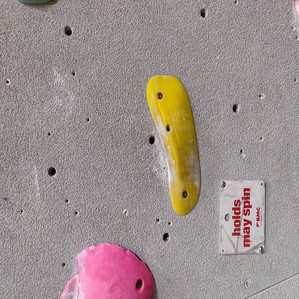

In [109]:
get_photo('8', 0, 'train')


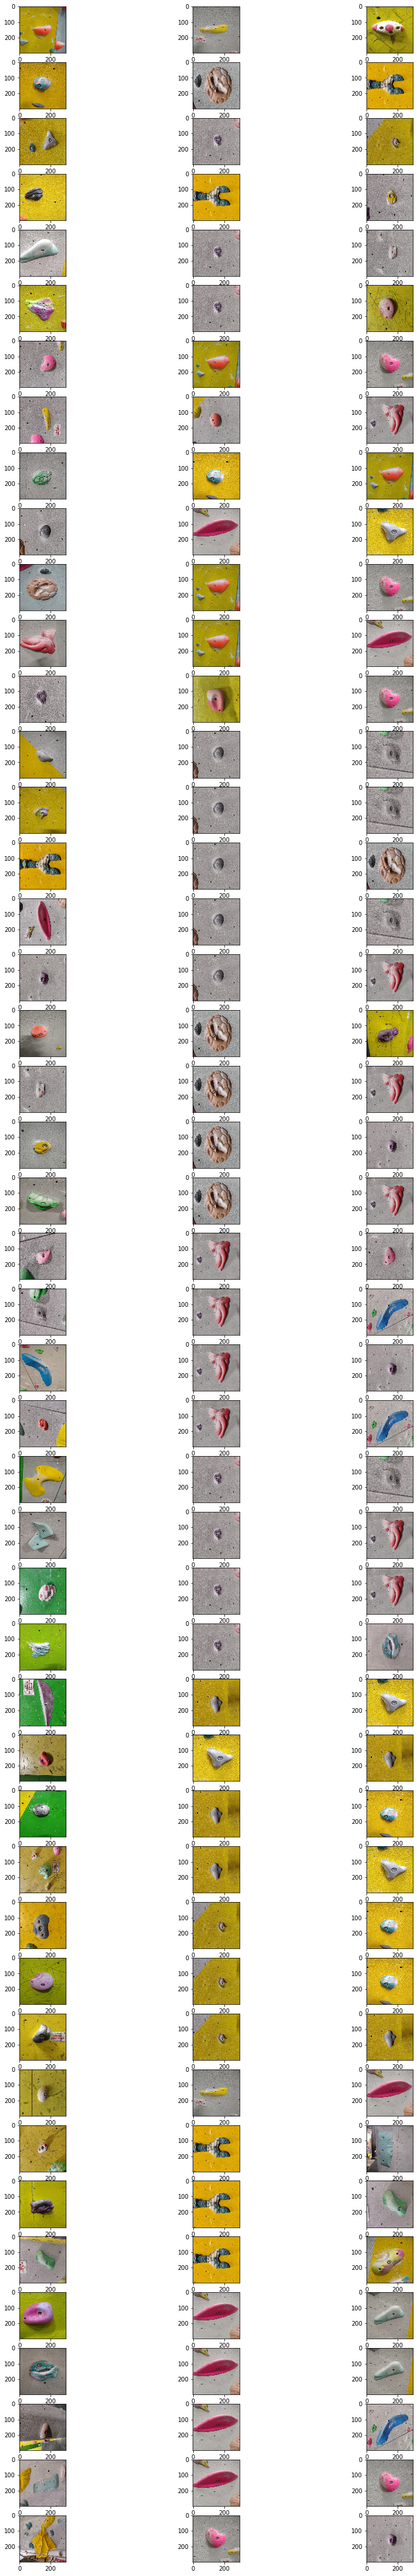

In [99]:
plot_results(list_of_cats)